# Web App Development

## UI/UX design

The goal is to build and deploy a simple Streamlit app. In v1, the user will be presented with a single button to "Get Headlines & Predict S&P500 Movement".

Pressing the button will trigger a function call to get 10 recent headlines. These will then be evaluated using the trained model, and their probabilities averaged to determine a final prediction.

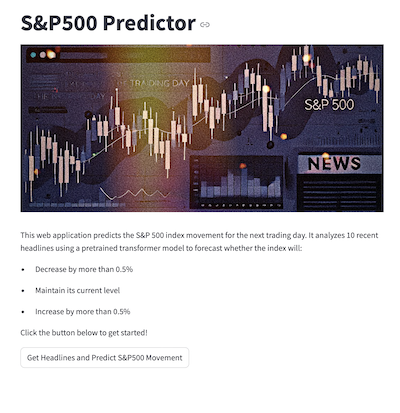
-->
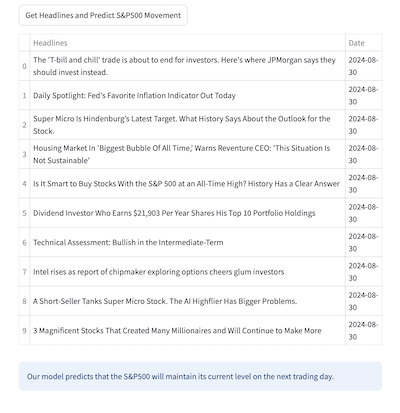

## Get Headlines

After some trial-and-error scraping different sources, using the FinNews library to get the 10 most recent headlines from the Yahoo Finance RSS feed seems to give the most consistent results.

In [4]:
import FinNews as fn
import pandas as pd
from datetime import date, timedelta

In [5]:
def get_headlines():
    yahoo = fn.Yahoo(topics=["*"])
    yahoo.get_news()
    df = yahoo.to_pandas()
    df = df[["title", "published"]]
    df["published"] = pd.to_datetime(df["published"])
    df["published"] = df["published"].dt.tz_localize(None).dt.date
    today = date.today()
    if df[df["published"] == today].empty:  # fallback option in case the function is called between midnight and the start of the next business day
        df = df[df["published"] == today - timedelta(days=1)]
    else:
        df = df[df["published"] == today]
    df.columns = ["Headlines", "Date"]
    df = df[~df["Headlines"].str.startswith(("Market Update", "Analyst Report"))] # these are published quite often, but headlines are not very informative
    df = df.head(10).reset_index(drop=True)
    return df

In [8]:
df = get_headlines()
df

,Headlines,Date
0,The 'T-bill and chill' trade is about to end f...,2024-08-30
1,Daily Spotlight: Fed's Favorite Inflation Indi...,2024-08-30
2,Is It Smart to Buy Stocks With the S&P 500 at ...,2024-08-30
3,"Dividend Investor Who Earns $21,903 Per Year S...",2024-08-30
4,Super Micro Is Hindenburg’s Latest Target. Wha...,2024-08-30
5,"Housing Market In 'Biggest Bubble Of All Time,...",2024-08-30
6,Technical Assessment: Bullish in the Intermedi...,2024-08-30
7,A Short-Seller Tanks Super Micro Stock. The AI...,2024-08-30
8,Intel rises as report of chipmaker exploring o...,2024-08-30
9,3 Magnificent Stocks That Created Many Million...,2024-08-30


## Predict S&P 500 movement

### Load the model and tokenizer from HuggingFace Hub

Model card: https://huggingface.co/jeroenvdmbrugge/sp500-predictor-individual-headlines

In [11]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

tokenizer = AutoTokenizer.from_pretrained("jeroenvdmbrugge/sp500-predictor-individual-headlines")
model = AutoModelForSequenceClassification.from_pretrained("jeroenvdmbrugge/sp500-predictor-individual-headlines")
pred = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
/Users/jeroen/anaconda/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


**Note:** skip 'device' argument to avoid issues when deploying to Streamlit cloud

### Get probabilities for each headline and store in the df

In [19]:
import torch 

def get_probabilities(headline, pred):
    result = pred(headline)
    scores = [label["score"] for label in result[0]]
    return torch.tensor(scores)

def apply_probabilities(df, pred):
    df["Probabilities"] = df["Headlines"].apply(lambda x: get_probabilities(x, pred))
    return df

In [21]:
df = apply_probabilities(df, pred)
df

,Headlines,Date,Probabilities
0,The 'T-bill and chill' trade is about to end f...,2024-08-30,"[tensor(0.3046), tensor(0.2023), tensor(0.4931)]"
1,Daily Spotlight: Fed's Favorite Inflation Indi...,2024-08-30,"[tensor(0.2311), tensor(0.4770), tensor(0.2920)]"
2,Is It Smart to Buy Stocks With the S&P 500 at ...,2024-08-30,"[tensor(0.1932), tensor(0.5485), tensor(0.2583)]"
3,"Dividend Investor Who Earns $21,903 Per Year S...",2024-08-30,"[tensor(0.2335), tensor(0.5076), tensor(0.2589)]"
4,Super Micro Is Hindenburg’s Latest Target. Wha...,2024-08-30,"[tensor(0.2059), tensor(0.5451), tensor(0.2490)]"
5,"Housing Market In 'Biggest Bubble Of All Time,...",2024-08-30,"[tensor(0.2436), tensor(0.4110), tensor(0.3455)]"
6,Technical Assessment: Bullish in the Intermedi...,2024-08-30,"[tensor(0.2404), tensor(0.3925), tensor(0.3672)]"
7,A Short-Seller Tanks Super Micro Stock. The AI...,2024-08-30,"[tensor(0.1522), tensor(0.6313), tensor(0.2165)]"
8,Intel rises as report of chipmaker exploring o...,2024-08-30,"[tensor(0.1948), tensor(0.5286), tensor(0.2766)]"
9,3 Magnificent Stocks That Created Many Million...,2024-08-30,"[tensor(0.2364), tensor(0.4644), tensor(0.2992)]"


### Average probabilities to determine final class

In [23]:
def get_final_class(df):
    prob_tensors = torch.stack(df["Probabilities"].tolist())
    average_probabilities = prob_tensors.mean(dim=0)
    class_labels = ['decrease', 'maintain', 'increase']
    final_class = class_labels[torch.argmax(average_probabilities).item()]
    return final_class

In [25]:
get_final_class(df)


'maintain'

### Build Streamlit app

Source code on GitHub: https://github.com/jeroenvdmbrugge/SP500-Predictor-WebApp

Try the app here: https://jvdm-sp500-predictor-webapp-v1.streamlit.app


In [28]:
'''
--- backend.py ---

import FinNews as fn
import pandas as pd
from datetime import date, timedelta
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch


tokenizer = AutoTokenizer.from_pretrained("jeroenvdmbrugge/sp500-predictor-individual-headlines")
model = AutoModelForSequenceClassification.from_pretrained("jeroenvdmbrugge/sp500-predictor-individual-headlines")
pred = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)

def get_headlines():
    yahoo = fn.Yahoo(topics=["*"])
    yahoo.get_news()
    df = yahoo.to_pandas()
    df = df[["title", "published"]]
    df["published"] = pd.to_datetime(df["published"])
    df["published"] = df["published"].dt.tz_localize(None).dt.date
    today = date.today()
    if df[df["published"] == today].empty:
        df = df[df["published"] == today - timedelta(days=1)]
    else:
        df = df[df["published"] == today]
    df.columns = ["Headlines", "Date"]
    df = df[~df["Headlines"].str.startswith(("Market Update", "Analyst Report"))]
    df = df.head(10).reset_index(drop=True)
    return df

def get_probabilities(headline, pred):
    result = pred(headline)
    scores = [label["score"] for label in result[0]]
    return torch.tensor(scores)

def apply_probabilities(df, pred):
    df["Probabilities"] = df["Headlines"].apply(lambda x: get_probabilities(x, pred))
    return df

def get_final_class(df):
    prob_tensors = torch.stack(df["Probabilities"].tolist())
    average_probabilities = prob_tensors.mean(dim=0)
    class_labels = ['decrease', 'maintain', 'increase']
    final_class = class_labels[torch.argmax(average_probabilities).item()]
    return final_class

if __name__ == "__main__":
    df = get_headlines()
    print(df.head())
    df = apply_probabilities(df, pred)
    print(df.head())
    final_class = get_final_class(df)
    print(final_class)

--- backend.py ---
''';

In [29]:
'''
--- app.py ---
import streamlit as st
from backend import get_headlines, apply_probabilities, get_final_class, pred

st.title("S&P500 Predictor")
st.image("header.png", use_column_width=True)
st.write("")
st.markdown("""
        This web application predicts the S&P 500 index movement for the next trading day. 
        It analyzes 10 recent headlines using a pretrained transformer model to forecast whether the index will:
        - Decrease by more than 0.5%\n
        - Maintain its current level\n
        - Increase by more than 0.5%\n
        Click the button below to get started!
         """)

if st.button('Get Headlines and Predict S&P500 Movement'):
    df = get_headlines()
    st.table(df)
    df = apply_probabilities(df, pred)
    final_class = get_final_class(df)
    if final_class == "decrease":
        st.info("Our model predicts that the S&P500 will decrease by more than 0.5% on the next trading day.")
    elif final_class == "maintain":
        st.info("Our model predicts that the S&P500 will maintain its current level on the next trading day.")
    else:
        st.info("Our model predicts that the S&P500 will increase by more than 0.5% on the next trading day.")

--- app.py ---
''';